# 1. Data Pre-Processing

### Import Library

In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split

### Folder Paths

In [2]:
# source_folder = folder penyimpanan kumpulan dataset yang masih tercampur atau belum dibagi menjadi train, test, dan validation
source_folder = "../dataset/ICDAR-2011"
# train_folder, test_folder, validation_folder = folder tujuan / tempat penyimpanan dataset setelah dibagi di bagian "Train and Test Data Split" 
train_folder = "../template/ICDAR-data/train"
test_folder = "../template/ICDAR-data/test"
validation_folder = "../template/ICDAR-data/validation"

### Train and Test Data Split

In [3]:
# Hanya membagi data, belum read / membaca gambar 

In [4]:
def extract_label(folder_name):
    return 0 if "_forg" in folder_name else 1

def split_data(source_folder, train_folder, test_folder, validation_folder):
    if not os.path.exists(train_folder):
        os.makedirs(train_folder)
    if not os.path.exists(test_folder):
        os.makedirs(test_folder)
    if not os.path.exists(validation_folder):
        os.makedirs(validation_folder)

    signatures = [folder for folder in os.listdir(source_folder) if os.path.isdir(os.path.join(source_folder, folder))]
    for signature in signatures:
        signature_path = os.path.join(source_folder, signature)
        images = os.listdir(signature_path)

        label = extract_label(signature)

        train_signature_temp, test_signature = train_test_split(images, test_size=0.2, random_state=3, stratify=[label]*len(images)) #stratify
        train_signature, validation_signature = train_test_split(train_signature_temp, test_size=0.25, random_state=3, stratify=[label]*len(train_signature_temp))

        for sig in train_signature:
            source_path = os.path.join(signature_path, sig)
            destination_path = os.path.join(train_folder, signature)
            if not os.path.exists(destination_path):
                os.makedirs(destination_path)
            destination_path = os.path.join(destination_path, sig)
            shutil.copy(source_path, destination_path)

        for sig in test_signature:
            source_path = os.path.join(signature_path, sig)
            destination_path = os.path.join(test_folder, signature)
            if not os.path.exists(destination_path):
                os.makedirs(destination_path)
            destination_path = os.path.join(destination_path, sig)
            shutil.copy(source_path, destination_path)

        for sig in validation_signature:
            source_path = os.path.join(signature_path, sig)
            destination_path = os.path.join(validation_folder, signature)
            if not os.path.exists(destination_path):
                os.makedirs(destination_path)
            destination_path = os.path.join(destination_path, sig)
            shutil.copy(source_path, destination_path)

In [5]:
# split_data(source_folder, train_folder, test_folder, validation_folder)

# 2. Feature Extraction

### Load vgg16 model

In [6]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np

### Extract Features

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
import cv2 as cv

In [8]:
size = 224

In [9]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(size, size, 3))
gap = GlobalAveragePooling2D()(base_model.output)
model = Model(inputs=base_model.input, outputs=gap)

for layer in base_model.layers:
    layer.trainable = False

model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [10]:
def extract_features(folder_path, batch_size=32):
    features = []
    names = []
    labels = []
    signatures = [folder for folder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, folder))]

    for signature in signatures:
        signature_path = os.path.join(folder_path, signature)
        images = os.listdir(signature_path)

        batch_features = []
        batch_names = []
        batch_labels = []

        for image_name in images:
            image_path = os.path.join(signature_path, image_name)
            # Read dan pre-processing gambar
            img = cv.imread(image_path)
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            img = cv.resize(img, (size, size))
            img = np.array(preprocess_input(img))

            batch_features.append(img)
            batch_names.append(signature[:3])

            if signature.endswith("_forg"):
                batch_labels.append(0)
            else:
                batch_labels.append(1)

            if len(batch_features) == batch_size:
                batch_features = np.array(batch_features)
                batch_features = model.predict(batch_features)
                batch_features = batch_features.reshape(len(batch_features), -1)

                features.extend(batch_features)
                names.extend(batch_names)
                labels.extend(batch_labels)

                batch_features = []
                batch_names = []
                batch_labels = []

        if batch_features:
            batch_features = np.array(batch_features)
            batch_features = model.predict(batch_features)
            batch_features = batch_features.reshape(len(batch_features), -1)

            features.extend(batch_features)
            names.extend(batch_names)
            labels.extend(batch_labels)

    return features, names, labels

In [11]:
# train_features, train_names, train_labels = extract_features(train_folder)
# test_features, test_names, test_labels = extract_features(test_folder)
# validation_features, validation_names, validation_labels = extract_features(validation_folder)

### Save and Load Features, Names, and Labels to reduce time needed

In [12]:
train_features_path =  "../template/ICDAR-feature/train_features.npy"
train_names_path = "../template/ICDAR-feature/train_names.npy"
train_labels_path = "../template/ICDAR-feature/train_labels.npy"

test_features_path = "../template/ICDAR-feature/test_features.npy"
test_names_path = "../template/ICDAR-feature/test_names.npy"
test_labels_path = "../template/ICDAR-feature/test_labels.npy"

validation_features_path = "../template/ICDAR-feature/validation_features.npy"
validation_names_path = "../template/ICDAR-feature/validation_names.npy"
validation_labels_path = "../template/ICDAR-feature/validation_labels.npy"

In [13]:
# np.save(train_features_path, train_features)
# np.save(train_names_path, train_names)
# np.save(train_labels_path, train_labels)

# np.save(test_features_path, test_features)
# np.save(test_names_path, test_names)
# np.save(test_labels_path, test_labels)

# np.save(validation_features_path, validation_features)
# np.save(validation_names_path, validation_names)
# np.save(validation_labels_path, validation_labels)

In [14]:
train_features = np.load(train_features_path)
train_names = np.load(train_names_path)
train_labels = np.load(train_labels_path)

test_features = np.load(test_features_path)
test_names = np.load(test_names_path)
test_labels = np.load(test_labels_path)

validation_features = np.load(validation_features_path)
validation_names = np.load(validation_names_path)
validation_labels = np.load(validation_labels_path)

In [15]:
print("train_features shape : ", train_features.shape)
print("test_features shape : ", test_features.shape)
print("validation_features shape : ", validation_features.shape)

train_features shape :  (857, 512)
test_features shape :  (401, 512)
validation_features shape :  (391, 512)


### Feature Gallery

In [16]:
# Feature Gallery dilakukan untuk setiap kelas / nama seperti "001", "002", "003", dst dengan cara mengambil data training positive dan mengambil mean / rata-rata dari data tersebut
def create_feature_gallery(train_features, train_names, train_labels):
    gallery_feature = []
    gallery_name = []

    unique_names = set(train_names.flatten())
    sorted_names = sorted(unique_names)

    for name in sorted_names:
        # print(name)
        # print(name)
        name_features = []

        for feature, feature_name, label in zip(train_features, train_names, train_labels):
            # print(feature, feature_name, label)
            if name in feature_name and label == 1:
                name_features.append(feature)

        if name_features:
            # print(name_features)
            average_feature = np.mean(name_features, axis=0)
            gallery_feature.append(average_feature)
            gallery_name.append(name)

    return gallery_feature, gallery_name

In [17]:
# gallery_features, gallery_names = create_feature_gallery(train_features, train_names, train_labels)

In [18]:
gallery_feature_path = "../template/ICDAR-feature/gallery_features.npy"
gallery_name_path = "../template/ICDAR-feature/gallery_names.npy"

In [19]:
# np.save(gallery_feature_path, gallery_features)
# np.save(gallery_name_path, gallery_names)

In [20]:
gallery_features = np.load(gallery_feature_path)
gallery_names = np.load(gallery_name_path)

In [21]:
gallery_features_array = np.array(gallery_features)
print("gallery features shape : ", gallery_features_array.shape)

gallery features shape :  (64, 512)


### Euclidean Distance

In [22]:
def euclidean_distance(feature_vector1, feature_vector2):
    return np.sqrt(np.sum((feature_vector1 - feature_vector2)**2))

In [23]:
def find_euclidean_distance(test_features, test_names, test_labels, gallery_features, gallery_names):
    euclidean_distances = []
    euclidean_names = []
    euclidean_actual_labels = []

    for gallery_feature, gallery_name in zip(gallery_features, gallery_names):
        curr_euclid_name = gallery_name
        curr_euclid_feature = []
        curr_euclid_label = []
        curr_euclid_dist = []
        for feature, name, label in zip(test_features, test_names, test_labels):
            if gallery_name in name:
                curr_euclid_feature.append(feature)
                curr_euclid_label.append(label)
        
        for feature in curr_euclid_feature:
            distance = euclidean_distance(feature, gallery_feature)
            curr_euclid_dist.append(distance)

        euclidean_distances.append(curr_euclid_dist)
        euclidean_names.append(curr_euclid_name)
        euclidean_actual_labels.append(curr_euclid_label)
        
    return euclidean_distances, euclidean_names, euclidean_actual_labels

In [24]:
test_euclidean_distances, test_euclidean_names, test_euclidean_actual_labels = find_euclidean_distance(test_features, test_names, test_labels, gallery_features, gallery_names)
train_euclidean_distances, train_euclidean_names, train_euclidean_actual_labels = find_euclidean_distance(train_features, train_names, train_labels, gallery_features, gallery_names)
validation_euclidean_distances, validation_euclidean_names, validation_euclidean_actual_labels = find_euclidean_distance(validation_features, validation_names, validation_labels, gallery_features, gallery_names)

### Split Euclidean Distance to Positive and Negative for Future Use (If needed)

In [25]:
def split_euc_dist(euclidean_distances, euclidean_names, euclidean_actual_labels):
    positive_distance = []
    positive_name = []
    positive_label = []
    negative_distance = []
    negative_name = []
    negative_label = []

    for euclidean_distance, euclidean_name, euclidean_actual_label in zip(euclidean_distances, euclidean_names, euclidean_actual_labels):
        pos_dist = []
        neg_dist = []
        pos_lab = []
        neg_lab = []
        for distance, label in zip(euclidean_distance, euclidean_actual_label):
            if label == 0:
                neg_dist.append(distance)
                neg_lab.append(label)
            else:
                pos_dist.append(distance)
                pos_lab.append(label)

        positive_distance.append(pos_dist)
        positive_name.append(euclidean_name)
        positive_label.append(pos_lab)

        negative_distance.append(neg_dist)
        negative_name.append(euclidean_name)
        negative_label.append(neg_lab)
        # print(euclidean_distance, euclidean_name, euclidean_actual_label)

    return positive_distance, negative_label

In [26]:
train_positive_dist, train_negative_dist = split_euc_dist(train_euclidean_distances, train_names, train_euclidean_actual_labels)
test_positive_dist, test_negative_dist = split_euc_dist(test_euclidean_distances, test_names, test_euclidean_actual_labels)
validation_positive_dist, validation_negative_dist = split_euc_dist(validation_euclidean_distances, validation_names, validation_euclidean_actual_labels)

In [27]:
flat_train_positive_dist = [item for sublist in train_positive_dist for item in sublist]
flat_train_negative_dist = [item for sublist in train_negative_dist for item in sublist]
flat_test_positive_dist = [item for sublist in test_positive_dist for item in sublist]
flat_test_negative_dist = [item for sublist in test_negative_dist for item in sublist]
flat_validation_positive_dist = [item for sublist in validation_positive_dist for item in sublist]
flat_validation_negative_dist = [item for sublist in validation_negative_dist for item in sublist]

print(f'Train total : {len(flat_train_positive_dist) + len(flat_train_negative_dist)}')
print(f'  Train pos : {len(flat_train_positive_dist)}')
print(f'  Train neg : {len(flat_train_negative_dist)}')
print(f' Test total : {len(flat_test_positive_dist) + len(flat_test_negative_dist)}')
print(f'   Test pos : {len(flat_test_positive_dist)}')
print(f'   Test neg : {len(flat_test_negative_dist)}')
print(f'  Val total : {len(flat_validation_positive_dist) + len(flat_validation_negative_dist)}')
print(f'    Val pos : {len(flat_validation_positive_dist)}')
print(f'    Val neg : {len(flat_validation_negative_dist)}')

Train total : 857
  Train pos : 463
  Train neg : 394
 Test total : 401
   Test pos : 212
   Test neg : 189
  Val total : 391
    Val pos : 212
    Val neg : 179


### Normalize Euclidean Distance

In [28]:
# Flatten the lists of distances
flat_test_distances = [item for sublist in test_euclidean_distances for item in sublist]
flat_train_distances = [item for sublist in train_euclidean_distances for item in sublist]
flat_validation_distances = [item for sublist in validation_euclidean_distances for item in sublist]

In [29]:
print(flat_train_distances)

[13.6049595, 21.932959, 21.496456, 15.307754, 17.360264, 17.419003, 17.911547, 15.00951, 17.355019, 16.276554, 18.273987, 12.368687, 18.675575, 20.502789, 28.272856, 34.732773, 24.176556, 33.3398, 18.51894, 19.481525, 12.248274, 14.898222, 18.72175, 11.35333, 12.044213, 11.968388, 11.557663, 14.413532, 12.622269, 17.348131, 19.835333, 27.133863, 24.609848, 26.387075, 25.235922, 27.822554, 22.213787, 45.627037, 14.824518, 17.712778, 21.489483, 21.16146, 22.580687, 23.389305, 18.937662, 28.622076, 28.459631, 32.85015, 30.861513, 23.943705, 32.683014, 27.106833, 57.106064, 52.177784, 32.550224, 42.41868, 44.196136, 30.13137, 24.728722, 22.719225, 16.465508, 21.463211, 14.689658, 15.622107, 18.843342, 19.464495, 18.075893, 21.851465, 22.206976, 25.088398, 23.628038, 23.006983, 25.213789, 43.784546, 33.35936, 27.575056, 33.78753, 33.839516, 19.020607, 18.832644, 23.530853, 21.256655, 19.957914, 20.854757, 18.69372, 19.86964, 19.426579, 15.240164, 24.195028, 18.263596, 22.539003, 21.362715, 

In [30]:
def get_min_max(euclidean_distances):
    min_distance = min(euclidean_distances)
    max_distance = max(euclidean_distances)

    return min_distance, max_distance

In [31]:
min_val, max_val = get_min_max(flat_train_distances)
print(f'min: {min_val}, max: {max_val}')

min: 6.250149726867676, max: 57.10606384277344


In [32]:
def normalize_distance(euclidean_distances, min_val, max_val):
    all_distance = []

    for distance in euclidean_distances:
        normalized_distance = (distance - min_val) / (max_val - min_val)

        # in case test and train distances are beyond max of train
        if normalized_distance > 1:
            normalized_distance = 1
        elif normalized_distance < 0:
            normalized_distance = 0
        
        all_distance.append(normalized_distance)

    return all_distance

def reverse_normalized_distance(euclidean_distances, min_val, max_val):
    reverse_distance = []
    normalized_distances = normalize_distance(euclidean_distances, min_val, max_val)
    for distance in normalized_distances:
        distance = -distance
        reverse_distance.append(distance)

    return reverse_distance

In [33]:
# normalized_positive_distances = reverse_normalized_distance(positive_distance)
# normalized_negative_distances = reverse_normalized_distance(negative_distance)

In [34]:
normalized_test_euclidean_distance = reverse_normalized_distance(flat_test_distances, min_val, max_val)
normalized_train_euclidean_distance = reverse_normalized_distance(flat_train_distances, min_val, max_val)
normalized_validation_euclidean_distance = reverse_normalized_distance(flat_validation_distances, min_val, max_val)

In [35]:
print(normalized_test_euclidean_distance)

[-0.2542256, -0.23537022, -0.29414472, -0.15490597, -0.16482513, -0.47296745, -0.43287742, -0.30000266, -0.17319685, -0.18513288, -0.1410424, -0.19797681, -0.8869253, -0.87010527, -0.7749768, -0.51007986, -0.4314125, -0.3772247, -0.41234115, -0.39609873, -0.6457173, -0.5739204, -0.60348904, -0.27834493, -0.28279793, -0.3849205, -0.32266095, -0.44766632, -0.58465177, -0.37876302, -0.63124675, -0.30577826, -0.26076755, -0.26411477, -0.27208787, -0.29079148, -0.65965134, -0.5245042, -0.5530759, -0.2916792, -0.4407237, -0.21151006, -0.26321656, -0.28693214, -0.48907432, -0.4714368, -0.39116883, -0.2504883, -0.17001568, -0.20560692, -0.09551062, -0.0914489, -0.5089318, -0.5342436, -0.46714354, -0.19726346, -0.09213635, -0.2982936, -0.59855366, -0.7805705, -0.597225, -0.17057496, -0.22335483, -0.12643571, -0.10188033, -0.12825502, -0.41764313, -0.2710715, -0.3625197, -0.36862063, -0.18953696, -0.21210867, -0.099469654, -0.15394695, -0.09574504, -0.4468078, -0.3800868, -0.5761388, -0.40937218

# 3. ROC Curve

In [36]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

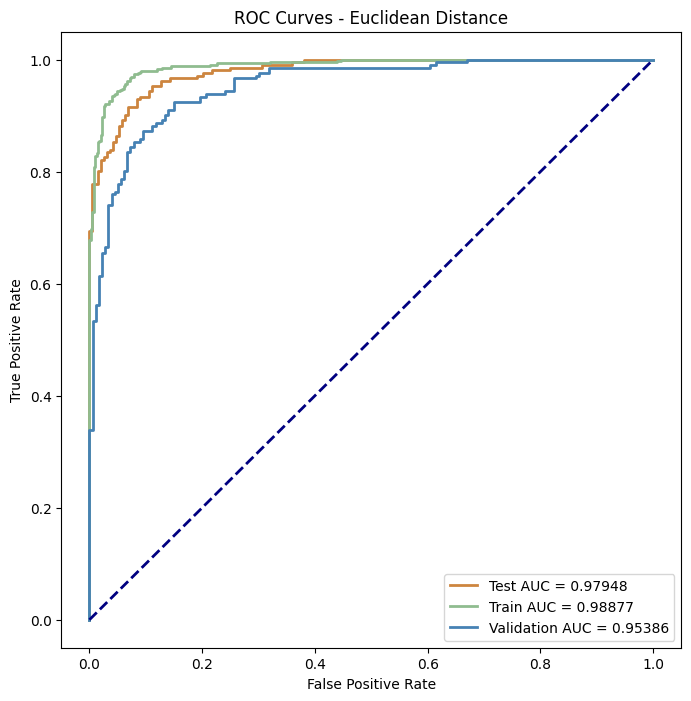

In [37]:
# Flatten the lists of labels
flat_test_labels = [item for sublist in test_euclidean_actual_labels for item in sublist]
flat_train_labels = [item for sublist in train_euclidean_actual_labels for item in sublist]
flat_validation_labels = [item for sublist in validation_euclidean_actual_labels for item in sublist]

# Calculate ROC curve
fpr_test, tpr_test, thresholds_test = roc_curve(flat_test_labels, normalized_test_euclidean_distance, drop_intermediate=False)
roc_auc_test = auc(fpr_test, tpr_test)
fpr_train, tpr_train, thresholds_train = roc_curve(flat_train_labels, normalized_train_euclidean_distance, drop_intermediate=False)
roc_auc_train = auc(fpr_train, tpr_train)
fpr_validation, tpr_validation, thresholds_validation = roc_curve(flat_validation_labels, normalized_validation_euclidean_distance, drop_intermediate=False)
roc_auc_validation = auc(fpr_validation, tpr_validation)

# Plot ROC curve
plt.figure(figsize=(8, 8))

plt.plot(fpr_test, tpr_test, color='peru', lw=2, label=f'Test AUC = {roc_auc_test:.5f}')
plt.plot(fpr_train, tpr_train, color='darkseagreen', lw=2, label=f'Train AUC = {roc_auc_train:.5f}')
plt.plot(fpr_validation, tpr_validation, color='steelblue', lw=2, label=f'Validation AUC = {roc_auc_validation:.5f}')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Euclidean Distance')
plt.legend(loc='lower right')
plt.show()

In [38]:
print(tpr_test)

[0.         0.00471698 0.00943396 0.01415094 0.01886792 0.02358491
 0.02830189 0.03301887 0.03773585 0.04245283 0.04716981 0.05188679
 0.05660377 0.06132075 0.06603774 0.07075472 0.0754717  0.08018868
 0.08490566 0.08962264 0.09433962 0.0990566  0.10377358 0.10849057
 0.11320755 0.11792453 0.12264151 0.12735849 0.13207547 0.13679245
 0.14150943 0.14622642 0.1509434  0.15566038 0.16037736 0.16509434
 0.16981132 0.1745283  0.17924528 0.18396226 0.18867925 0.19339623
 0.19811321 0.20283019 0.20754717 0.21226415 0.21698113 0.22169811
 0.22641509 0.23113208 0.23584906 0.24056604 0.24528302 0.25
 0.25471698 0.25943396 0.26415094 0.26886792 0.27358491 0.27830189
 0.28301887 0.28773585 0.29245283 0.29716981 0.30188679 0.30660377
 0.31132075 0.31603774 0.32075472 0.3254717  0.33018868 0.33490566
 0.33962264 0.34433962 0.3490566  0.35377358 0.35849057 0.36320755
 0.36792453 0.37264151 0.37735849 0.38207547 0.38679245 0.39150943
 0.39622642 0.4009434  0.40566038 0.41037736 0.41509434 0.41981132
 

In [39]:
print(fpr_test)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

In [40]:
def find_tpr_at_fpr(fpr, tpr, target_fpr):
    return np.interp(target_fpr, fpr, tpr)

In [41]:
target_fprs = [0.1, 0.01, 0.001]
tpr_at_target_fpr_train = [find_tpr_at_fpr(fpr_train, tpr_train, fpr) for fpr in target_fprs]
tpr_at_target_fpr_test = [find_tpr_at_fpr(fpr_test, tpr_test, fpr) for fpr in target_fprs]
tpr_at_target_fpr_val = [find_tpr_at_fpr(fpr_validation, tpr_validation, fpr) for fpr in target_fprs]

In [42]:
print("Test")
for tpr, fpr in zip(tpr_at_target_fpr_test, target_fprs):
    print(f'TPR at FPR {fpr:.3f}: {tpr:.3f}')
print(f'             AUC: {roc_auc_test}')

print("Train")
for tpr, fpr in zip(tpr_at_target_fpr_train, target_fprs):
    print(f'TPR at FPR {fpr:.3f}: {tpr:.3f}')
print(f'             AUC: {roc_auc_train}')

print("Validation")
for tpr, fpr in zip(tpr_at_target_fpr_val, target_fprs):
    print(f'TPR at FPR {fpr:.3f}: {tpr:.3f}')
print(f'             AUC: {roc_auc_validation}')

Test
TPR at FPR 0.100: 0.934
TPR at FPR 0.010: 0.778
TPR at FPR 0.001: 0.693
             AUC: 0.9794848757112908
Train
TPR at FPR 0.100: 0.981
TPR at FPR 0.010: 0.808
TPR at FPR 0.001: 0.678
             AUC: 0.9887678021291292
Validation
TPR at FPR 0.100: 0.873
TPR at FPR 0.010: 0.533
TPR at FPR 0.001: 0.340
             AUC: 0.95385791082534
